<a href="https://colab.research.google.com/github/vhaghani26/BST_227_Code/blob/main/Assignment_2_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Assignment 2 Part 2 - Introduction**
By: Mariele Lensink and Viktoria Haghani

This notebook sets up a simple variational autoencoder for DNA sequences, where $X_i$ represents sequence $i$ of length $L$, and $Z_i$ represents the latent variable corresponding to sequence $i$. The underlying probabilistic model implemented here is:

$Z_i \sim N(0, I_K)$

$X_{i,j} \sim \mbox{Discrete}(f_d(\vec{p}_{i,j} | Z_i, \theta_d))$

Where $f_d$ represents a decoder neural net, whose parameters are represented by $\theta_d$, and that predicts a probability distribution (over bases) for each position $j$ of sequence $i$.

The approximate posterior distribution $q(Z_i|X_i)$, implemented by the decoder, is implemented as $q(Z_i|X_i) = N(Z_i | f_e(\mu | X, \theta_e), f_e(\sigma|X,\theta_e)^2I_K))$.


# **Updated Model**

Import required packages

In [ ]:
import torch
import torch.optim as optim
from torch.distributions import RelaxedOneHotCategorical

In [ ]:
## Plot
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def plot_scatter(X_in, label, method = 'pca'):
    """ Create scatterplots of data x with label after dimensionality reduction (if needed) """

    if X_in.shape[-1] > 2:
      if method == 'pca':
        pca = PCA(2)
        X_plot = pca.fit_transform(X_in)
      elif method == 'tsne':
        tsne = TSNE(2)
        X_plot = tsne.fit_transform(X_in)
      elif method == 'umap':
        reducer = umap.UMAP(2)
        X_plot  = reducer.fit_transform(X_in)
    else:
      X_plot = X_in

    df = pd.DataFrame(X_plot)
    df['Label'] = np.array(label).tolist()
    df.columns = ['X','Y','Label']
    df.sort_values(by=['Label'],inplace=True)
    _, ax = plt.subplots(figsize=[15,10])
    sns.scatterplot(data=df,
                    x='X',
                    y='Y',
                    hue='Label',
                    ax = ax)


# **Set up input dataset with datasets and dataloader**

Load data

In [ ]:
import pandas as pd
import io
import requests
from tqdm import tqdm
import numpy as np

from sklearn.preprocessing import OneHotEncoder

#----------------------------------------
#from Chenxi Liu
#function for downloading sequence data from Box and converting to one-hot encoding
#note this function actually returns the summary statistics over the data, which is
#just the total number of each bases across all input sequences for our simple 
#latent variable model.
#
# this function by default returns a summary of all data.
def get_sequence(url, categories=['A', 'C', 'G', 'T']):
  r = requests.get(url)
  df = pd.read_csv(io.StringIO(r.text), sep=" ", header=None)
  s1 = np.array(list(str(df.to_numpy()[0, :][0])), dtype=object).reshape(-1, 1)

  m = len(df)
  sequence_len = len(list(df.iloc[0, :].values)[0])
  data = np.zeros((m, sequence_len, len(categories)))
  
  ohe = OneHotEncoder(sparse=False, categories=[np.array(categories, dtype=object)])
  example_sequence = np.array(list(str(df.to_numpy()[0, :][0])), dtype=object).reshape(-1, 1)

  ohe.fit(s1)

  for ii in tqdm(range(m)):
    
    s = list(str(df.to_numpy()[ii, :][0]))
    s_a = np.array(s).reshape(-1, 1)
    data[ii, :, :] = ohe.transform(s_a)

  return data


In [ ]:
#URL for at_gc_sequences.txt - this is a single sequence:
# ATTTAATATAAAATTTGGCCGCCATAAAAAAA
#https://ucdavis.box.com/shared/static/s8g6zx9vwxbbfdxdj2uqzhlvslc1jhsy.txt
#URL for sequence.padded.txt - the real binding site data
#https://ucdavis.box.com/shared/static/0cacx2xvn4ugxo9h21ci2ngesryigf43.txt
#URL for sequence.motiflocation.padded.txt - the location of the binding sites from sequence.padded.txt
#https://ucdavis.box.com/shared/static/gd0r12mdkhix86bo9ffbn3dy0fy0prmn.txt

XX_sequences_padded = get_sequence('https://ucdavis.box.com/shared/static/0cacx2xvn4ugxo9h21ci2ngesryigf43.txt')

#get the locations of the binding sites
CC_sequences_padded = pd.read_csv(io.StringIO(requests.get('https://ucdavis.box.com/shared/static/gd0r12mdkhix86bo9ffbn3dy0fy0prmn.txt').text), sep=",", header=None).to_numpy()

100%|██████████| 357/357 [00:00<00:00, 2526.47it/s]


Create a custom dataset class

In [ ]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    """ Custom dataset """

    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        sample = {"X"  : self.X[idx],
                  "Y" : self.Y[idx]}

        return sample


Create datasets and dataloaders

In [ ]:
# Shuffle XX_sequences_padded
X = XX_sequences_padded
Y = CC_sequences_padded

X_long = np.argmax(X,-1)
Y_long = np.argmax(Y,-1)
counts = np.array([np.sum(X_long==ii,0) for ii in range(4)])
pd.DataFrame(counts)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37
0,100,94,98,116,107,92,90,94,98,88,78,153,181,30,21,13,1,329,49,67,51,22,63,172,39,47,31,61,86,100,92,94,105,100,95,78,79,90
1,89,71,84,76,95,101,81,92,85,91,160,52,16,2,24,24,350,5,122,62,64,38,26,101,260,283,90,93,87,84,89,103,82,75,83,87,108,86
2,84,99,78,80,84,62,75,81,82,78,64,44,152,273,312,34,1,1,113,149,148,24,260,21,4,4,1,135,83,95,89,88,86,100,88,95,88,88
3,84,93,97,85,71,102,111,90,92,100,55,108,8,52,0,286,5,22,73,79,94,273,8,63,54,23,235,68,101,78,87,72,84,82,91,97,82,93


In [ ]:
def shuffle_motif(X, position, length):
  """ Given array X """
  idx = np.arange(len(X))
  idx_shortened = list(idx[:position]) + [idx[position:position+length]] + list(idx[position+length:])
  np.random.shuffle(idx_shortened)

  position_new = np.where(np.array([np.array([ii]).shape[-1] for ii in idx_shortened])!=1)[0][0]
  idx_shuffled = np.concatenate([np.array(ii).reshape(-1,1) for ii in idx_shortened],0).reshape(-1)
  y = np.zeros(len(X))
  y[position_new] = 1

  return X[idx_shuffled],y 

idx_10 = np.argmax(Y,-1)==10
X_10 = X[idx_10]
X_10_shuffled = [shuffle_motif(X_, 10, 18) for X_ in X_10]
Y_10_shuffled = np.array([y for _,y in X_10_shuffled])
X_10_shuffled = np.array([x for x,_ in X_10_shuffled])

X[idx_10] = X_10_shuffled
Y[idx_10] = Y_10_shuffled

In [ ]:
from sklearn.model_selection import train_test_split

batch_size = 4
X = torch.tensor(X).float()
Y = torch.tensor(Y).float()

print(X.shape)
print(Y.shape)

# Split train/test
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,train_size=0.8)

# Create datasets
trainset = CustomDataset(X,Y)
testset  = CustomDataset(X,Y) 
# trainset = CustomDataset(X_train,Y_train)
# testset  = CustomDataset(X_test,Y_test) 

# Create dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


torch.Size([357, 38, 4])
torch.Size([357, 38])


In [ ]:
pd.DataFrame(torch.max(Y,1)[1].numpy()).value_counts() # Show distribution of positions

20    25
7     24
8     23
15    21
2     20
18    19
5     19
14    18
3     18
1     17
6     16
10    16
9     15
4     15
0     15
19    14
13    14
12    13
16    13
11    12
17    10
dtype: int64

#### Test the iterator by printing out the next batch

In [ ]:
# get some random training images
dataiter = iter(trainloader)
dataset_dict = dataiter.next()
print(dataset_dict['X'].shape) # (n_batch, *(n_dimensions))

torch.Size([4, 38, 4])


# **Set up model**

Define VAE

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.kl import kl_divergence as kl_div
from torch.distributions.kl import register_kl


from torch.distributions import RelaxedOneHotCategorical, Categorical, Normal

class NetVAE(nn.Module):
    # weights initialization with default method similar to kaiming
    def __init__(self, mode='flatten', latent_dist='cat', num_category = 4, latent_dim=16):

        super().__init__()

        self.latent_dim = latent_dim
        self.latent_dist = latent_dist
        self.mode   = mode
        self.num_category = num_category

        self.drop = nn.Dropout(0.2)
        self.softplus = torch.nn.Softplus()
        self.softmax = torch.nn.Softmax()

        # Flattening method
        self.fc1 = nn.Linear(38 * 4, 96)

        # Set prior based on the latent_dim type
        if latent_dist == 'gaus':
          self.prior = torch.distributions.Normal(torch.zeros(self.latent_dim), 
                                                  torch.ones(self.latent_dim))
          d_in = self.latent_dim * 2 # for mu,var
          d_out = self.latent_dim
        
        # Set priors
        elif latent_dist == 'cat':
          temperature = 0.5
          randprobs = torch.rand(self.latent_dim)
          self.prior = RelaxedOneHotCategorical(torch.tensor(temperature), probs = torch.tensor(randprobs))
          # Match dimensions to number of categories 
          d_in = self.latent_dim
          d_out = self.latent_dim   
        
        else:
          raise ValueError()

        # encoder
        self.fc2 = nn.Linear(96,d_in)

        # decoder
        self.fc3 = nn.Linear(d_out,96)
        self.fc4 = nn.Linear(96,38*4) # predict flattened version

    # Forward pass
    def forward(self, x, return_latent = False):

        x = torch.flatten(x, 1) # flatten all dimensions except batch

        # encoder
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)

        if self.latent_dist == 'gaus':
          # Set parameters
          z_mu, z_var = torch.chunk(x,2,dim=-1) # split output into mu,var
          z_var = self.softplus(z_var)
          # Posterior distribution
          z_dist = Normal(z_mu,z_var)
          # Sample
          x = z_dist.rsample()
          

        elif self.latent_dist == 'cat':
          # Posterior distribution
          temperature = 0.5
          m = self.softmax(x)
          z_dist = RelaxedOneHotCategorical(torch.tensor(temperature), probs=torch.tensor(m)) 
          # Sample 
          x = z_dist.rsample()

        # decoder
        x = F.relu(self.fc3(x))
        x = self.drop(x)

        # Final output layer
        x = self.fc4(x)
        if return_latent:
          out = (x, z_dist)
        else:
          out = x

        return out

## Set functions for initializing weights 
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

Set up SummaryWriter for tensorboard

In [ ]:
rm -r ./runs

In [ ]:
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms

# Writer will output to ./runs/ directory by default
writer = SummaryWriter()

# **Train the model**

In [ ]:
from torch.optim.lr_scheduler import ExponentialLR

#set up model, loss, and optimizer (L2 applied for all weights)
#can switch between 'gaus' and 'cat'
model = NetVAE(latent_dist='cat', latent_dim=16)

net = model
# net.apply(init_weights) # custom initialization

criterion = torch.nn.CrossEntropyLoss(reduction='sum')
# optimizer = optim.SGD(net.parameters(), lr=1e-4, momentum=0.9, weight_decay=1e-3) 
optimizer = optim.AdamW(net.parameters(), lr=1e-3, weight_decay=1e-4) 
scheduler = ExponentialLR(optimizer, gamma=0.9)
# weight decay = L2 regularization
# lr = learning rate
# gamma = decay rate per epoch

num_epoch = 100

#optimize
for epoch in range(num_epoch):  # loop over the dataset multiple times
    running_loss = 0.0
    running_loss_kl = 0.0
    running_loss_recon = 0.0
    
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data['X'],data['Y']

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, z_dist = net(inputs, return_latent=True)

        # Input is one-hot encoding so CrossEntropy can still be used
        inputs_long = torch.max(torch.reshape(inputs,(-1,4)),1)[1] # [n_seq * len_seq, 4]
        if net.latent_dist == 'gaus':
          kl_loss = kl_div(net.prior,z_dist).sum(-1).sum()
        elif net.latent_dist == 'cat':
          kl_loss = kl_div(Categorical(probs=net.prior.probs),Categorical(probs=z_dist.probs)).sum(-1).sum()
        recon_loss = criterion(outputs.view(-1,4), inputs_long)
        loss = kl_loss + recon_loss

        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_loss_kl += kl_loss.item()
        running_loss_recon += recon_loss.item()

    print('[epoch %d] loss: %.3f' % (epoch + 1, running_loss / i))
    writer.add_scalar('Loss/train', running_loss/i, epoch + 1)
    writer.add_scalar('LossRecon/train', running_loss_recon/i, epoch + 1)
    writer.add_scalar('LossKL/train', running_loss_kl/i, epoch + 1)

writer.close()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[epoch 1] loss: 212.264
[epoch 2] loss: 211.447
[epoch 3] loss: 211.147
[epoch 4] loss: 211.260
[epoch 5] loss: 211.185
[epoch 6] loss: 211.222
[epoch 7] loss: 211.143
[epoch 8] loss: 211.223
[epoch 9] loss: 211.207
[epoch 10] loss: 211.201
[epoch 11] loss: 211.037
[epoch 12] loss: 211.182
[epoch 13] loss: 211.130
[epoch 14] loss: 211.250
[epoch 15] loss: 210.968
[epoch 16] loss: 211.080
[epoch 17] loss: 211.090
[epoch 18] loss: 211.078
[epoch 19] loss: 211.094
[epoch 20] loss: 211.114
[epoch 21] loss: 211.080
[epoch 22] loss: 211.058
[epoch 23] loss: 211.059
[epoch 24] loss: 210.991
[epoch 25] loss: 211.079
[epoch 26] loss: 210.986
[epoch 27] loss: 211.033
[epoch 28] loss: 211.060
[epoch 29] loss: 211.073
[epoch 30] loss: 211.014
[epoch 31] loss: 211.020
[epoch 32] loss: 210.985
[epoch 33] loss: 211.033
[epoch 34] loss: 210.998
[epoch 35] loss: 211.022
[epoch 36] loss: 210.926
[epoch 37] loss: 211.011
[epoch 38] loss: 211.012
[epoch 39] loss: 211.013
[epoch 40] loss: 210.929
[epoch 41

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs

#it's helpful to unclick "ignore outliers in chart scaling"

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 5479), started 0:34:01 ago. (Use '!kill 5479' to kill it.)

<IPython.core.display.Javascript object>

Plot 2D scatter of latent embedding space
Only for AE

In [ ]:
# get some random test datasets
dataset_dict = testset[:]
X = dataset_dict["X"]
Y = dataset_dict["Y"]

labels_long = torch.max(Y,1)[1].numpy().astype('str')
X_flattened = X.reshape(len(X),-1).numpy()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


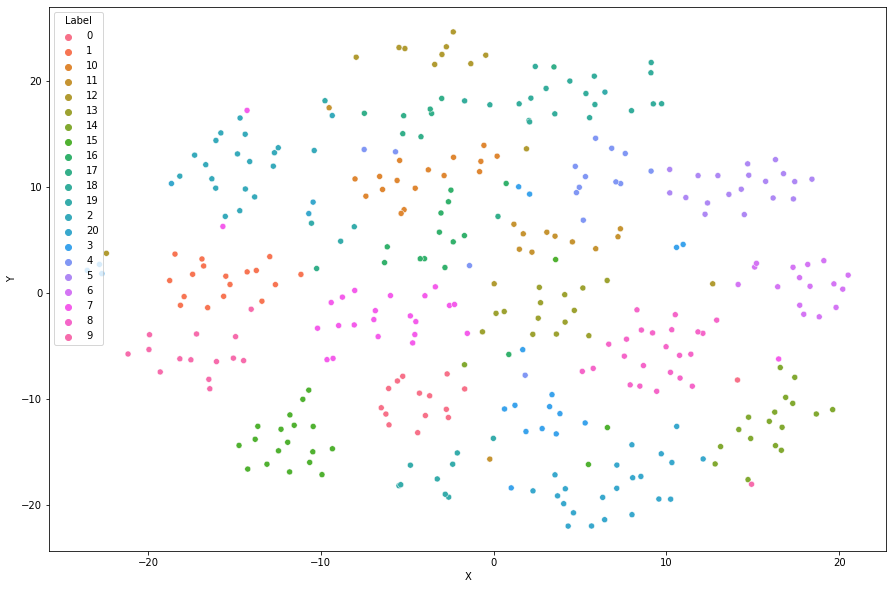

In [ ]:
# tsne on original input data
plot_scatter(X_flattened, labels_long, method='tsne')

In [ ]:
# tsne on latent space
with torch.no_grad():
  X_recon, z = net(X, return_latent=True)

if model.latent_dist == 'cat':
  X_plot = torch.max(z.probs,1)[1] # for categorical prior
  X_plot = X_plot.reshape(-1,1)
elif model.latent_dist == 'gaus':
  X_plot = z.mean # for gaussian prior

plot_scatter(X_plot.detach().numpy(), labels_long, method='tsne')

In [ ]:
## Show comparisons between the original and reconstructed X

idx_unique = np.array([np.where(labels_long==ii)[0][0] for ii in np.unique(labels_long)])

input    = X[idx_unique]
labels   = Y[idx_unique]
target   = torch.max(labels,1)[1] # target class index for ground truth label

with torch.no_grad():
  X_recon= net(input)

input_long   = torch.max(input,-1)[1]
X_recon_long = torch.max(X_recon.reshape(len(X_recon),38,4),-1)[1]

## Full sequence
df_list = []
bases = np.array(["A","C","G","T"])
for ii,orig,pred in zip(target,input_long,X_recon_long):
  df_list.append((pd.DataFrame({f"Pos{ii}-Orig":bases[orig],
                                f"Pos{ii}-Pred":bases[pred]}).transpose()))

pd.concat(df_list)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37
Pos0-Orig,C,T,A,G,G,T,C,A,C,T,G,T,A,A,C,C,T,C,C,A,A,C,C,T,C,T,T,A,G,A,G,T,A,C,A,A,T,A
Pos0-Pred,A,A,T,A,G,G,G,A,A,G,A,G,G,G,C,G,C,G,G,T,C,C,C,G,C,T,C,A,C,C,T,T,C,C,C,C,T,A
Pos1-Orig,G,C,T,G,G,G,T,C,A,T,G,T,T,G,A,C,C,T,A,C,G,C,G,G,A,A,C,T,T,A,C,T,T,A,A,T,A,T
Pos1-Pred,A,A,T,A,G,A,G,A,A,G,A,G,G,G,C,G,C,G,G,T,C,C,C,G,C,T,C,A,C,C,T,T,C,C,C,C,T,A
Pos10-Orig,T,C,T,A,A,C,T,A,C,T,C,A,G,G,G,T,C,A,G,T,C,T,G,T,C,C,T,G,T,C,G,T,C,T,G,A,T,C
Pos10-Pred,A,G,T,A,G,A,G,A,A,G,A,G,G,T,C,A,C,G,G,G,C,C,C,G,C,T,C,A,C,C,T,T,C,C,C,C,T,A
Pos11-Orig,C,G,A,A,A,G,C,T,G,C,C,A,A,A,G,G,T,C,A,T,G,G,T,G,C,C,C,T,G,C,G,T,G,A,G,T,G,G
Pos11-Pred,A,A,T,A,G,G,G,A,A,G,A,G,G,G,C,C,C,G,G,T,C,C,C,G,C,T,C,A,C,C,T,T,C,C,C,C,T,T
Pos12-Orig,A,A,C,A,G,A,C,G,A,A,T,A,G,A,G,G,G,T,C,A,T,G,A,T,G,A,C,C,T,A,T,G,C,G,T,C,A,G
Pos12-Pred,A,A,T,A,G,G,G,A,A,G,A,G,G,G,C,C,C,G,T,G,C,C,C,G,C,T,C,C,C,C,T,T,C,C,C,C,T,A


In [ ]:
## Show only the motifs
df_list = []
for ii,orig,pred in zip(target,input_long,X_recon_long):
  df_list.append((pd.DataFrame({f"Pos{ii}-Orig":bases[orig[ii:ii+18]],
                                f"Pos{ii}-Pred":bases[pred[ii:ii+18]]}).transpose()))

pd.concat(df_list)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
Pos0-Orig,C,T,A,G,G,T,C,A,C,T,G,T,A,A,C,C,T,C
Pos0-Pred,A,A,T,A,G,G,G,A,A,G,A,G,G,G,C,G,C,G
Pos1-Orig,C,T,G,G,G,T,C,A,T,G,T,T,G,A,C,C,T,A
Pos1-Pred,A,T,A,G,A,G,A,A,G,A,G,G,G,C,G,C,G,G
Pos10-Orig,C,A,G,G,G,T,C,A,G,T,C,T,G,T,C,C,T,G
Pos10-Pred,A,G,G,T,C,A,C,G,G,G,C,C,C,G,C,T,C,A
Pos11-Orig,A,A,A,G,G,T,C,A,T,G,G,T,G,C,C,C,T,G
Pos11-Pred,G,G,G,C,C,C,G,G,T,C,C,C,G,C,T,C,A,C
Pos12-Orig,G,A,G,G,G,T,C,A,T,G,A,T,G,A,C,C,T,A
Pos12-Pred,G,G,C,C,C,G,T,G,C,C,C,G,C,T,C,C,C,C


# **Question 1**

We want to train a VAE to learn latent represntations $Z_i$ of each of the input sequences from Assignment 1. However, as the model is implemented above, the continuous representation $Z_i$ is hard to interpret; what does the continuous representation of a discrete sequence mean? 

We are therefore inspired to try to make the model more 'interpretable' by thinking back to Assignment 1, where our hidden variables $C_i$ represented the location of the motif in sequence $i$. In this scenario, the hidden variable $C_i$ is discrete (it was the position of the motif).

Here we will modify the VAE above, to make the latent variable $Z_i$ discrete, and will check against the dataset from Assignment 1 to see if the latent variable we learn indeed corresponds to the true motif location.

Modify this model to the following:

$Z_i \sim \mbox{Discrete}(1/K,...,1/K)$

$X_{i,j} \sim \mbox{Discrete}(f_d(\vec{p}_{i,j} | Z_i, \theta_d))$

$q(Z_i | X_i) = \mbox{Discrete}(f_e(p_i | X_i, \theta_e))$

Where $p_i$ is a vector of probabilities, predicted by the encoder, that forms a distribution over the possible discrete states of $Z_i$.

**Answer**: See model above

# **Question 2**

Train this model on the same dataset as Assignment 1 (as is done in the original model). Calculate a confusion matrix: that is, calculate a $K \times K$ table $M$, where $M[a,b]$ is the number of sequences where $Z_i = a$, and the actual motif position is $b$. Does our latent variable $Z_i$ give accurate 1-1 matchings to the motif location in each sequence $i$? Why or why not?



In [ ]:
import numpy as np
import sklearn
from sklearn.metrics import confusion_matrix

true_motifs = []
for i in range(len(CC_sequences_padded)):
  # Find motif location by maximum index
  one_true_motif = np.argmax(CC_sequences_padded[i])
  # Add  motif location to a list
  true_motifs.append(one_true_motif)

pred_motifs = []
for i in labels_long:
  pred_motifs.append(int(i))

my_confusion_matrix = sklearn.metrics.confusion_matrix(true_motifs, pred_motifs, labels=None, sample_weight=None, normalize=None)
print(my_confusion_matrix)

[[15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 16  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 24  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 23  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 15  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 16  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 12  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 13  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 14  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 18  0  0  0  0  0  0]
 [ 0  0  0

No, they do not match 1-1. This is because the model is not 100% accurate in predicting motif locations given the training set.

# **Question 3**

Part of the notebook below (now above, under "Original Model") draws a visual representation of the latent variables $Z_i$ in a 2D scatterplot, and colors each sequence based on the known motif location. You can see, when $Z_i$ is continuous, the sequences generally cluster by motif location pretty accurately. Modify the code to visualize the sequences based on the distribution $q(Z_i|X_i)$. How does the visualization compare to the notebook below? Which model (discrete or continuous $Z_i$) leads to latent representations in which sequences with the same motif location cluster?